Импортируем необходимые библиотеки и определим входные параметры

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

h=0.05 #м
A=55 #вт/(м град)
B=-150 #вт/(м2 град)
C=10 #вт/м3
D=100 #1/м^2
E=2

T1=20 #C
T2=800 #C
ALFA1=25.0 #Вт/(m^2*град)
ALFA2=46.5 #Вт/(m^2*град)

n = 100
dx = h/n

Функция расчёта коэффициентов левой части матрицы

In [2]:
def create_marix_left_side(kx, n, ALFA1, ALFA2, dx):
    matrix = [0] * (n)
    for i in range(n):
        matrix[i] = [0] * (n)
        if(i == 0):
            matrix[i][i] = 1
            matrix[i][i+1] = (-1)*kx[i]/(kx[i] + dx*ALFA1)
        elif(i == n-1):
            matrix[i][i] = 1
            matrix[i][i-1] = (-1)*kx[i]/(kx[i] + dx*ALFA2)
        else:
            matrix[i][i-1] = (kx[i-1]+4*kx[i]-kx[i+1])/(4*(dx**2))
            matrix[i][i] = (-2) * kx[i]/(dx **2)
            matrix[i][i+1] = ((-1) * kx[i-1]+4*kx[i]+kx[i+1])/(4*(dx**2))
    return matrix

Функция расчёта коэффициентов правой части матрицы

In [3]:
def create_matrix_right_side(fx, kx, n, ALFA1, ALFA2, dx):
    f = [0] * (n)
    for i in range(n):
        if(i == 0):
            f[i] = ALFA1*T1/(kx[i]/dx+ALFA1)
        elif(i == n-1):
            f[i] = ALFA2*T2/(kx[i]/dx+ALFA2)
        else:
            f[i] = fx[i]
    return f

Функция проверки входной матрицы на разрешимость 

In [4]:
def check_tdma_matrix(matrix, n):
    if(abs(matrix[0][1]) > 1) or (abs(matrix[n-1][n-1]) > 1) or (abs(matrix[0][1]) + abs(matrix[n-1][n-1]) >= 2):
        return False
    for i in range(n-1):
        if(i == 0):
            continue
        if(abs(matrix[i][i]) < abs(matrix[i][i-1]) + abs(matrix[i][i+1])):
            return False
    return True

Функция решения СЛАУ методом прогонки

In [5]:
def tdma_solve(matrix, f, n):
    
    if(not check_tdma_matrix(matrix, n)):
        raise ValueError("Метод прогонки не подходит для данной матрицы")
        
    P = [0] * (n)
    Q = [0] * (n)
    temperature_vector = [0] * (n)
    for i in range(n):
        if(i == 0):
            P[i] = (-1) * matrix[i][i+1]/matrix[i][i]
            Q[i] = f[i] / matrix[i][i]
        elif(i == n-1):
            P[i] = 0
            Q[i] = (f[i] - matrix[i][i-1] * Q[i-1]) / (matrix[i][i] + matrix[i][i-1] * P[i-1])
        else:
            gamma = matrix[i][i] + matrix[i][i-1] * P[i-1]
            P[i] = (-1) * matrix[i][i+1]/gamma
            Q[i] = (f[i] - matrix[i][i-1] * Q[i-1]) / gamma


    for i in reversed(range(n)):
        if(i == n-1):
            temperature_vector[i] = Q[i]
        else:
            temperature_vector[i] = P[i]* temperature_vector[i+1] + Q[i]
    
    return temperature_vector


Функция расчета потока через стенку

In [6]:
def compute_flux(temperature_vector, n, dx):
    flux = [0] * (n)

    for i in range(n):
        if(i == 0):
            grad_T = (temperature_vector[i+1] - temperature_vector[i])/dx
        elif(i == n-1):
            grad_T = (temperature_vector[i] - temperature_vector[i-1])/dx
        else:
            grad_T = (temperature_vector[i+1] - temperature_vector[i-1])/(2 * dx)
        flux[i] = (-1)*kx[i]*grad_T
    return flux

Функция вывода графика с результатами 

In [7]:
def show_plot(data, title, xlabel, ylable):
    fixture_x_range = []
    for i in range(n):
        fixture_x_range.append(i*dx)
    plt.plot(fixture_x_range,data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylable)
    plt.show()

Расчет значений функций f(x) и k(x)

In [8]:
fx = []
kx = []
for i in range(n):
    kx.append(A+B*i*dx)
    fx.append(C * math.exp((-1)*D * ((i*dx - h)/E) ** 2))

Рассчитаем коэффициенты левой и правой части матрицы

In [9]:
matrix = create_marix_left_side(kx, n, ALFA1, ALFA2, dx)
f = create_matrix_right_side(fx, kx, n, ALFA1, ALFA2, dx)

Решим СЛАУ двумя способами: через метод прогонки и методом из numpy

In [10]:
temperature_tdma = tdma_solve(matrix, f, n)
temperature_numpy = np.linalg.solve(matrix, f) 

Рассчитаем поток через стенку

In [11]:
flux = compute_flux(temperature_tdma, n, dx)

Выведем графики

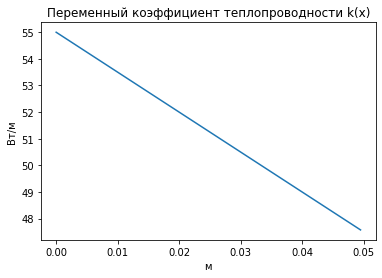

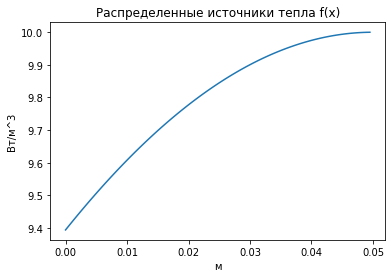

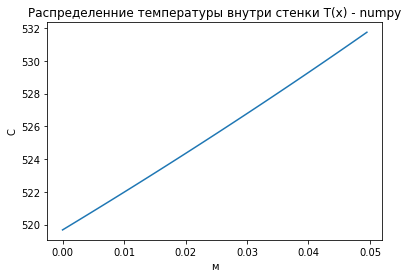

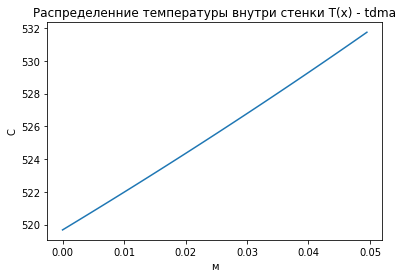

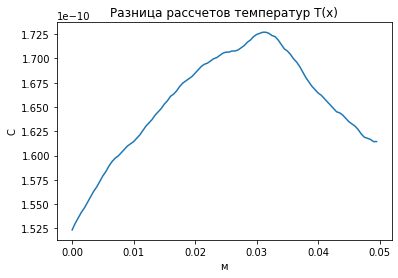

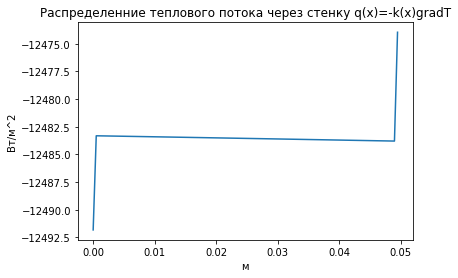

In [12]:
show_plot(kx, 'Переменный коэффициент теплопроводности k(x)', 'м', 'Вт/м')
show_plot(fx, 'Распределенные источники тепла f(x)', 'м', 'Вт/м^3')
show_plot(temperature_numpy, 'Распределенние температуры внутри стенки T(x) - numpy', 'м', 'C')
show_plot(temperature_tdma, 'Распределенние температуры внутри стенки T(x) - tdma', 'м', 'C')
show_plot(list(map(lambda x,y: x - y, temperature_numpy, temperature_tdma)), 'Разница рассчетов температур T(x)', 'м', 'C')
show_plot(flux, 'Распределенние теплового потока через стенку q(x)=-k(x)gradT', 'м', 'Вт/м^2')